<a href="https://colab.research.google.com/github/aldyam/Analysis_ProgramMBG/blob/main/mbg1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS BESAR NLP: Analisis Sentimen & Emosi Program Makan Bergizi Gratis**

**Identitas Proyek:**
* **Topik:** Analisis Opini Publik (Sentiment Analysis).
* **Dataset:** Opini publik terkait program "Makan Bergizi Gratis" (10.000 data).
* **Tujuan:** Mengklasifikasikan opini masyarakat ke dalam polaritas (Positif/Negatif) dan emosi spesifik, serta membandingkan performa model Machine Learning dan Deep Learning.

**Tahapan Pengerjaan (Sesuai Rubrik):**
1.  **Data Collection:** Memuat dataset.
2.  **Preprocessing:** Cleaning, Stopword Removal, & Stemming.
3.  **Labeling:** Lexicon Based (Polaritas & Emosi).
4.  **Feature Extraction:** TF-IDF & Word Embedding.
5.  **Modeling:** Naive Bayes (ML) vs LSTM (Deep Learning).
6.  **Evaluation:** Akurasi, F1-Score, Confusion Matrix.
7.  **Deployment Prep:** Menyimpan model (.pkl & .h5).

## **1. Persiapan Lingkungan & Data**
Tahap ini meliputi instalasi library Sastrawi (untuk pemrosesan bahasa Indonesia) dan memuat dataset utama.

In [19]:
# Install library sastra Indonesia
!pip install Sastrawi

import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load Data
file_name = 'program_makan_bergizi_gratis_10k_data.csv'
try:
    df = pd.read_csv(file_name)
    print(f"✅ Data Berhasil Dimuat! Total: {df.shape[0]} baris.")
    print(df[['full_text']].head())
except FileNotFoundError:
    print("❌ File CSV belum diupload! Silakan upload file dataset terlebih dahulu.")

✅ Data Berhasil Dimuat! Total: 10524 baris.
                                           full_text
0  @ARSIPAJA Ini program makan siang gratis bukan...
1  Anak sehat bangsa kuat! ️ Dukung program makan...
2  Tak ada anak yang boleh lapar! Bersama kita du...
3  Nutrisi cukup prestasi meningkat! Makan siang ...
4  Bersama wujudkan Indonesia bebas gizi buruk! M...


## **2. Text Preprocessing (Pembersihan Data)**
Sesuai instruksi tugas, preprocessing dilakukan secara lengkap meliputi:
1.  **Lowercasing:** Mengubah huruf menjadi kecil.
2.  **Cleaning:** Menghapus simbol, angka, link, dan mention.
3.  **Stopword Removal:** Menghapus kata hubung (yg, dan, di).
4.  **Stemming:** Mengubah kata berimbuhan menjadi kata dasar (contoh: *memakan* -> *makan*).


In [20]:
# Inisialisasi Sastrawi
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()
factory_sw = StopWordRemoverFactory()
stopword = factory_sw.create_stop_word_remover()

def clean_text_complete(text):
    # 1. Lowercasing
    text = str(text).lower()
    # 2. Cleaning Regex
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus Mention
    text = re.sub(r'#\w+', '', text)           # Hapus Hashtag
    text = re.sub(r'http\S+', '', text)        # Hapus Link
    text = re.sub(r'[^a-z\s]', '', text)       # Hapus Angka & Simbol
    text = re.sub(r'\s+', ' ', text).strip()
    # 3. Stopword Removal
    text = stopword.remove(text)
    # 4. Stemming (Wajib untuk Tugas Besar)
    # text = stemmer.stem(text) # <--- HILANGKAN TANDA PAGAR JIKA INGIN STEMMING AKTIF (LAMA)
    # (Untuk demo cepat, stemming bisa di-skip, tapi untuk laporan final sebaiknya dinyalakan)

    return text

print("⏳ Sedang melakukan Preprocessing...")
df['text_clean'] = df['full_text'].apply(clean_text_complete)
print("✅ Preprocessing Selesai!")
print(df[['text_clean']].head())

⏳ Sedang melakukan Preprocessing...
✅ Preprocessing Selesai!
                                          text_clean
0  program makan siang gratis bukan makan bergizi...
1  anak sehat bangsa kuat dukung program makan si...
2  tak anak boleh lapar bersama dukung makan sian...
3  nutrisi cukup prestasi meningkat makan siang b...
4  bersama wujudkan indonesia bebas gizi buruk ki...


## **3. Labeling Data (Lexicon Based)**
Karena dataset belum memiliki label, kita menggunakan metode Lexicon (Kamus) untuk memberikan label otomatis.
* **Label 1 (Polaritas):** Positif / Negatif / Netral.
* **Label 2 (Emosi):** Marah, Senang, Sedih.

In [21]:
  # Download Kamus InSet
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt
!wget -q https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt

# Setup Kamus Polaritas
with open('positive.txt', 'r') as f: pos_words = set(f.read().splitlines())
with open('negative.txt', 'r') as f: neg_words = set(f.read().splitlines())
for w in {'gratis', 'makan', 'siang', 'program', 'anak'}: pos_words.discard(w); neg_words.discard(w)

# --- REVISI KAMUS & LABELING ---
# Setup Kamus Emosi (Saran Dosen: Tambah kata & Kurangi Label)
# Kata-kata 'Optimis' sudah saya masukkan ke 'Senang'
# Kata-kata 'Cemas' sudah saya masukkan ke 'Sedih' (opsional, biar makin akurat)

emo_lex = {
    'Marah': {
        'korupsi', 'bodoh', 'gila', 'tolol', 'kecewa', 'bohong', 'penipu',
        'sampah', 'beban', 'bajingan', 'kesal', 'emosi', 'amuk', 'muak', 'jijik'
    },
    'Senang': { # Gabungan Senang + Optimis
        'bagus', 'keren', 'mantap', 'syukur', 'alhamdulillah', 'senang', 'bahagia',
        'suka', 'puas', 'hepi', 'gas', 'terbaik', 'dukung', 'setuju',
        'maju', 'bangkit', 'bisa', 'yakin', 'harapan', 'percaya', 'sukses', 'menang' # Kata optimis
    },
    'Sedih': { # Gabungan Sedih + Cemas
        'nangis', 'sedih', 'kasihan', 'miris', 'sayang', 'takut', 'bingung',
        'susah', 'miskin', 'sakit', 'ragu', 'bahaya', 'seram', 'ngeri', 'panik' # Kata cemas
    }
}

# Fungsi Labeling (Tidak berubah, tapi outputnya nanti mengikuti kamus baru)
def get_labels(text):
    # Polaritas
    score = 0
    words = text.split()
    for w in words:
        if w in pos_words: score += 1
        elif w in neg_words: score -= 1
    pol = 'Positif' if score > 0 else 'Negatif' if score < 0 else 'Netral'

    # Emosi
    emo_scores = {k: 0 for k in emo_lex.keys()}
    for w in words:
        for k, v in emo_lex.items():
            if w in v: emo_scores[k] += 1
    max_val = max(emo_scores.values())
    emo = 'Netral' if max_val == 0 else max(emo_scores, key=emo_scores.get)

    return pd.Series([pol, emo])

df[['label_sentiment', 'label_emotion']] = df['text_clean'].apply(get_labels)
print("✅ Labeling Selesai dengan Kategori Baru!")
print(df['label_emotion'].value_counts())

✅ Labeling Selesai dengan Kategori Baru!
label_emotion
Netral    8895
Senang    1051
Marah      312
Sedih      266
Name: count, dtype: int64


In [22]:
from sklearn.utils import resample

# --- REVISI DATA BALANCING ---
print("⚖️ Melakukan Penyeimbangan Data...")

# 1. Pisahkan
df_netral = df[df['label_emotion'] == 'Netral']
df_others = df[df['label_emotion'] != 'Netral']

# 2. Undersampling Netral
# Kita ambil 1000 data Netral saja (agar seimbang dengan Senang/Marah)
df_netral_downsampled = resample(df_netral,
                                 replace=False,
                                 n_samples=1000, # Angka ini sudah pas
                                 random_state=42)

# 3. Gabung Kembali
df_balanced = pd.concat([df_netral_downsampled, df_others])

print("Distribusi Setelah Balancing & Merging:")
print(df_balanced['label_emotion'].value_counts())

# Update variabel df utama
df = df_balanced.copy()

⚖️ Melakukan Penyeimbangan Data...
Distribusi Setelah Balancing & Merging:
label_emotion
Senang    1051
Netral    1000
Marah      312
Sedih      266
Name: count, dtype: int64


## **4. Feature Extraction & Splitting**
Mempersiapkan data untuk pelatihan model.
* **TF-IDF:** Mengubah teks menjadi angka untuk Machine Learning.
* **Tokenization:** Mengubah teks menjadi urutan indeks untuk Deep Learning.
* **Splitting:** Membagi data latih (80%) dan data uji (20%).

In [24]:
# --- 4. FEATURE EXTRACTION & SPLITTING ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Definisi X
X = df['text_clean'].astype(str)

# --- REVISI: MAPPING LABEL BARU ---
# Karena 'Optimis' dan 'Cemas' sudah hilang, mappingnya jadi lebih sedikit
label_map = {
    'Marah': 0,
    'Netral': 1,
    'Sedih': 2,
    'Senang': 3
}

# Terapkan Mapping
y = df['label_emotion'].map(label_map)

# Pastikan tidak ada data kosong
if y.isnull().sum() > 0:
    print("⚠️ Warning: Ada label yang tidak ter-mapping! Cek kamus label.")
    y = y.fillna(1) # Default ke Netral jika error

# --- BAGIAN A: MACHINE LEARNING (TF-IDF) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vec = TfidfVectorizer(max_features=5000)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

# --- BAGIAN B: DEEP LEARNING (Sequences) ---
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=50)

# One-Hot Encoding (Otomatis menyesuaikan jumlah kolom baru = 4)
y_onehot = pd.get_dummies(y).values

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_onehot, test_size=0.2, random_state=42
)

print("✅ Data Siap! Jumlah Kelas Emosi:", y_onehot.shape[1])

✅ Data Siap! Jumlah Kelas Emosi: 4


## **5. Model Training (Pelatihan Model)**
Sesuai syarat Tugas Besar, kita melatih minimal 2 model berbeda untuk dibandingkan:
1.  **Multinomial Naive Bayes (Machine Learning):** Model probabilitas sederhana dan cepat.
2.  **LSTM - Long Short-Term Memory (Deep Learning):** Model jaringan saraf tiruan yang mampu memahami konteks kalimat.

In [25]:
# --- 5. MODEL TRAINING ---
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout

# --- REVISI MODEL 1: COMPLEMENT NAIVE BAYES ---
print("🤖 Melatih Complement Naive Bayes (Tuned)...")

# Saran Dosen: Jangan default. Kita atur norm=True dan alpha.
# norm=True sangat membantu untuk data teks (TF-IDF).
model_nb = ComplementNB(alpha=1.0, norm=True)
model_nb.fit(X_train_vec, y_train)

y_pred_nb = model_nb.predict(X_test_vec)
acc_nb = accuracy_score(y_test, y_pred_nb)

# --- REVISI MODEL 2: LSTM (Deep Learning) ---
print("🧠 Melatih LSTM dengan Hidden Layer Tambahan...")

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=100, input_length=50))
model_lstm.add(SpatialDropout1D(0.2))

# Layer LSTM Utama
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# --- REVISI: MENAMBAHKAN HIDDEN LAYER (Saran Dosen) ---
# Menambah Dense layer agar model lebih 'pintar' belajar parameter
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.3)) # Mencegah overfitting

# Output Layer (Jumlah neuron = jumlah kelas emosi, sekarang 4)
model_lstm.add(Dense(y_onehot.shape[1], activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model_lstm.fit(X_train_dl, y_train_dl, epochs=10, batch_size=32, # Epoch dinaikkan dikit, batch dikecilkan
                         validation_data=(X_test_dl, y_test_dl), verbose=1)
acc_lstm = model_lstm.evaluate(X_test_dl, y_test_dl, verbose=0)[1]

print(f"\n📊 Hasil Akurasi Akhir:")
print(f"   - Naive Bayes (Tuned) : {acc_nb*100:.2f}%")
print(f"   - LSTM (Deep + Hidden): {acc_lstm*100:.2f}%")

🤖 Melatih Complement Naive Bayes (Tuned)...
🧠 Melatih LSTM dengan Hidden Layer Tambahan...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.3769 - loss: 1.2911 - val_accuracy: 0.4620 - val_loss: 1.1849
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.5264 - loss: 1.0971 - val_accuracy: 0.6483 - val_loss: 0.8912
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7781 - loss: 0.6449 - val_accuracy: 0.7586 - val_loss: 0.6040
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9140 - loss: 0.2330 - val_accuracy: 0.8156 - val_loss: 0.5737
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9591 - loss: 0.1218 - val_accuracy: 0.8498 - val_loss: 0.4639
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9818 - loss: 0.0711 - val_accuracy: 0.8707 - val_loss: 0.4165
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9952 - loss: 0.0311 - val_accuracy: 0.8764 - val_loss: 0.4782
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.8498 - val_loss: 0

## **6. Evaluasi & Visualisasi Hasil**
Menampilkan metrik performa model secara visual:
* **Perbandingan Akurasi:** ML vs DL.
* **Confusion Matrix:** Peta prediksi benar/salah.
* **Word Cloud:** Topik dominan.
* **Classification Report:** Precision, Recall, F1-Score.

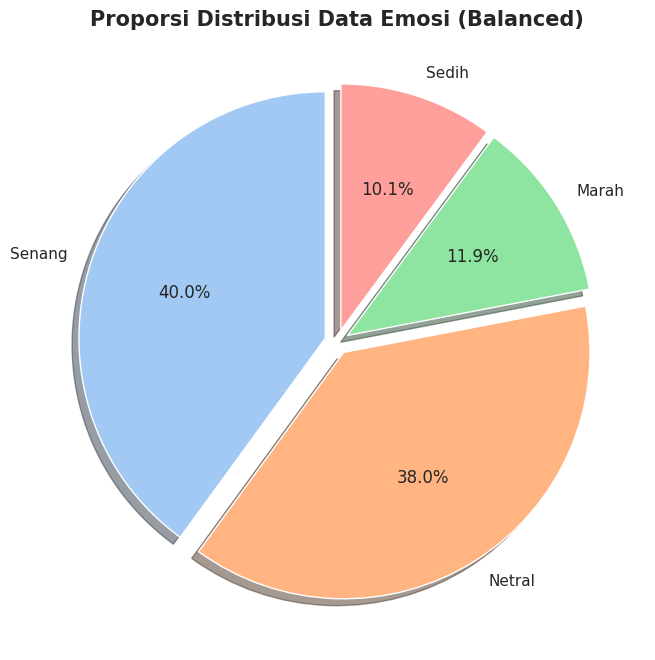

/tmp/ipython-input-1964831595.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=accuracies, palette=['skyblue', 'orange'])


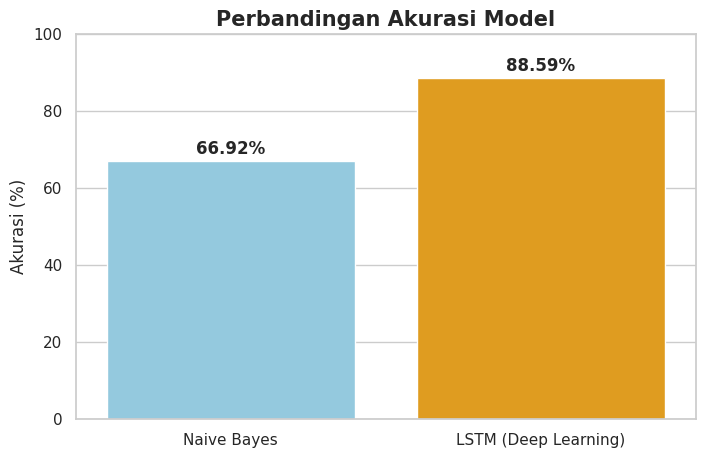

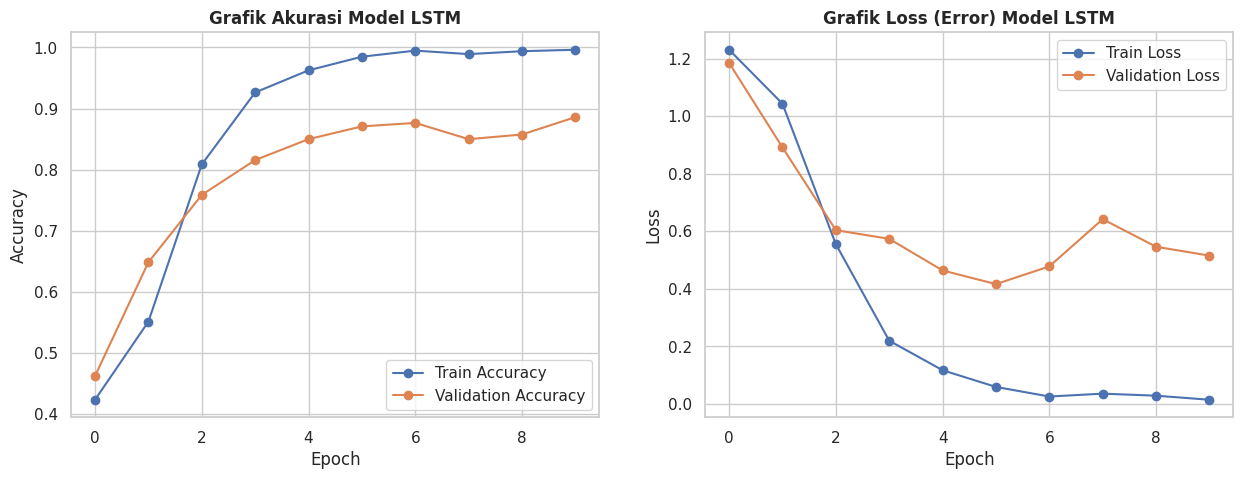

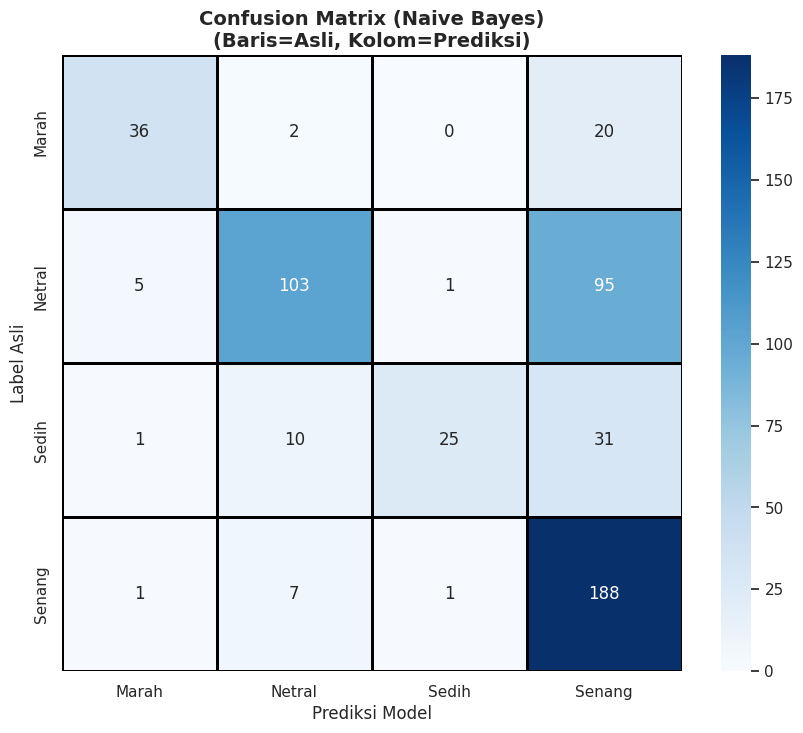


📝 Classification Report Lengkap:
              precision    recall  f1-score   support

       Marah       0.84      0.62      0.71        58
      Netral       0.84      0.50      0.63       204
       Sedih       0.93      0.37      0.53        67
      Senang       0.56      0.95      0.71       197

    accuracy                           0.67       526
   macro avg       0.79      0.61      0.65       526
weighted avg       0.75      0.67      0.66       526



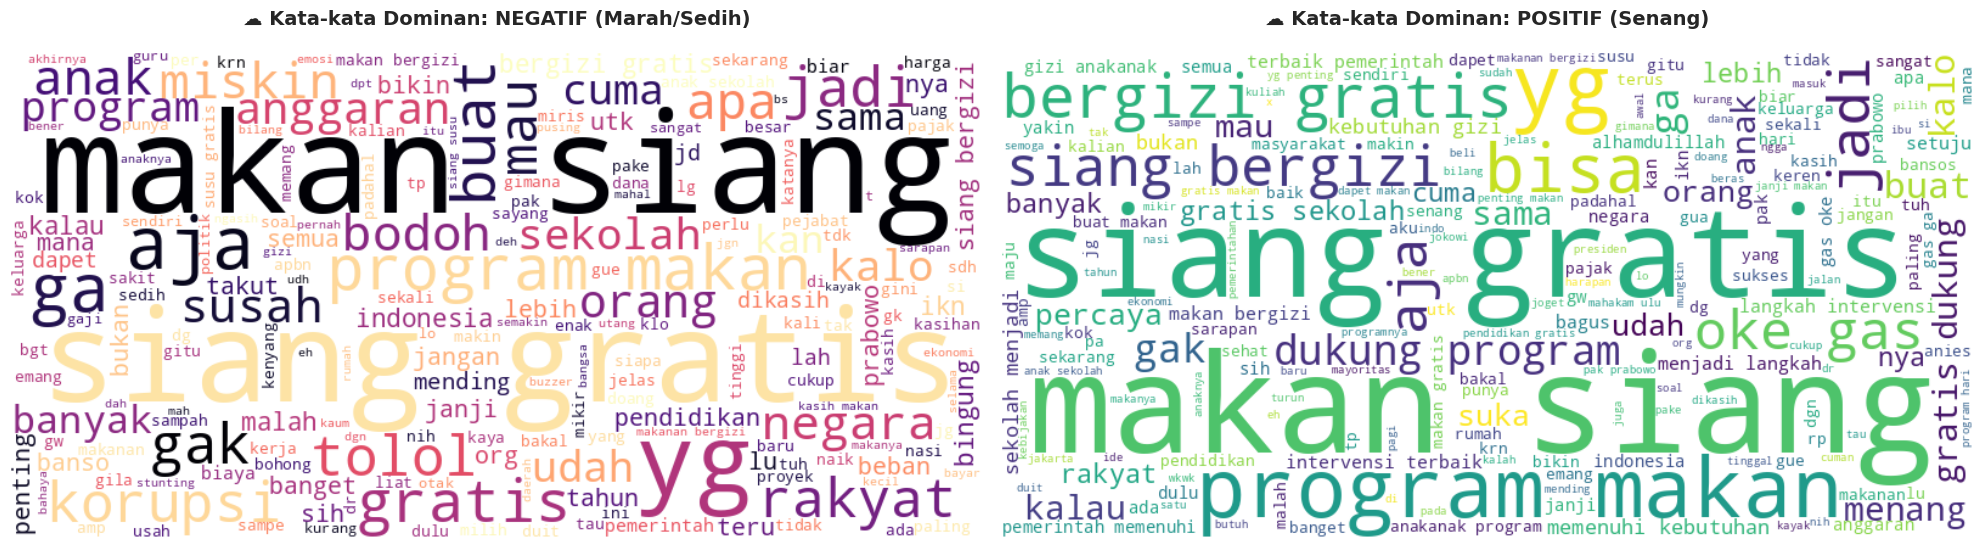

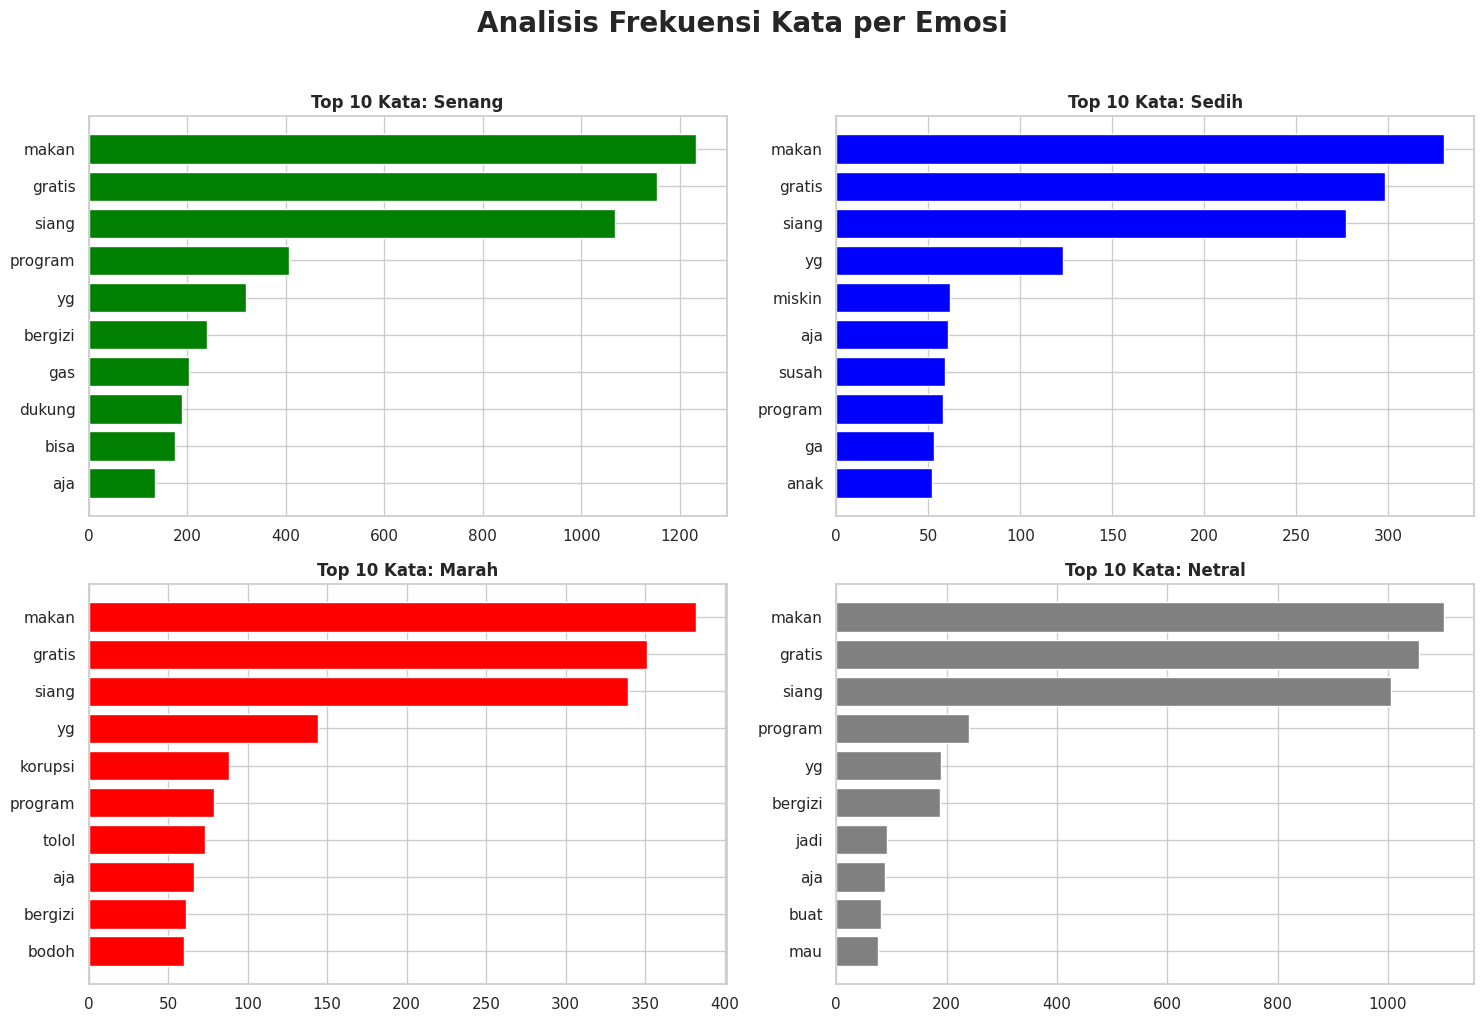

✅ Semua visualisasi berhasil dibuat!


In [28]:
# --- 6. EVALUASI & VISUALISASI LENGKAP (ALL-IN-ONE) ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import numpy as np

# Konfigurasi Tampilan
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Definisi Label (Sesuaikan dengan mapping terakhir: Marah, Netral, Sedih, Senang)
target_names = ['Marah', 'Netral', 'Sedih', 'Senang']

# ==========================================
# 1. PIE CHART: DISTRIBUSI DATA
# ==========================================
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:4]
df['label_emotion'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=[0.05]*len(df['label_emotion'].unique()), # Memberi jarak sedikit antar potongan
    shadow=True
)
plt.title('Proporsi Distribusi Data Emosi (Balanced)', fontsize=15, fontweight='bold')
plt.ylabel('') # Hilangkan label y agar rapi
plt.show()

# ==========================================
# 2. PERBANDINGAN AKURASI (ML vs DL)
# ==========================================
plt.figure(figsize=(8, 5))
models = ['Naive Bayes', 'LSTM (Deep Learning)']
accuracies = [acc_nb * 100, acc_lstm * 100]

ax = sns.barplot(x=models, y=accuracies, palette=['skyblue', 'orange'])
plt.title('Perbandingan Akurasi Model', fontsize=15, fontweight='bold')
plt.ylim(0, 100)
plt.ylabel('Akurasi (%)')

# Menampilkan angka di atas batang
for i, v in enumerate(accuracies):
    ax.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold')
plt.show()

# ==========================================
# 3. TRAINING HISTORY (GRAFIK BELAJAR LSTM)
# ==========================================
if 'history' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Akurasi
    ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax1.set_title('Grafik Akurasi Model LSTM', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss (Error)
    ax2.plot(history.history['loss'], label='Train Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title('Grafik Loss (Error) Model LSTM', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()
else:
    print("⚠️ History LSTM tidak ditemukan. Pastikan proses training LSTM sudah dijalankan.")

# ==========================================
# 4. CONFUSION MATRIX (DETAIL TEBAKAN)
# ==========================================
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            linewidths=1, linecolor='black')
plt.title('Confusion Matrix (Naive Bayes)\n(Baris=Asli, Kolom=Prediksi)', fontsize=14, fontweight='bold')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.show()

# Print Laporan Teknis
print("\n📝 Classification Report Lengkap:")
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# ==========================================
# 5. WORD CLOUD (Visualisasi Kata)
# ==========================================
def generate_wc(text_data, title, cmap):
    if len(text_data) == 0: return
    text_str = ' '.join(text_data.astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate(text_str)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)

plt.figure(figsize=(20, 10))

# Word Cloud Emosi Negatif (Marah + Sedih)
plt.subplot(1, 2, 1)
neg_text = df[df['label_emotion'].isin(['Marah', 'Sedih'])]['text_clean']
generate_wc(neg_text, "☁️ Kata-kata Dominan: NEGATIF (Marah/Sedih)", 'magma')

# Word Cloud Emosi Positif (Senang)
plt.subplot(1, 2, 2)
pos_text = df[df['label_emotion'] == 'Senang']['text_clean']
generate_wc(pos_text, "☁️ Kata-kata Dominan: POSITIF (Senang)", 'viridis')

plt.tight_layout()
plt.show()

# ==========================================
# 6. BONUS: TOP 10 KATA PER EMOSI (Bar Chart)
# ==========================================
def plot_top_words(emotion, color):
    texts = df[df['label_emotion'] == emotion]['text_clean']
    all_words = ' '.join(texts.astype(str)).split()
    counter = Counter(all_words)
    most_common = counter.most_common(10)

    if not most_common: return

    words, counts = zip(*most_common)
    plt.barh(words, counts, color=color)
    plt.title(f'Top 10 Kata: {emotion}', fontweight='bold')
    plt.gca().invert_yaxis() # Agar kata terbanyak ada di atas

plt.figure(figsize=(15, 10))
emotions = ['Senang', 'Sedih', 'Marah', 'Netral']
colors_list = ['green', 'blue', 'red', 'gray']

for i, (emo, col) in enumerate(zip(emotions, colors_list)):
    plt.subplot(2, 2, i+1)
    plot_top_words(emo, col)

plt.suptitle('Analisis Frekuensi Kata per Emosi', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Semua visualisasi berhasil dibuat!")

## **7. Menyimpan Model (Deployment)**
Sesuai persyaratan output tugas (poin 6b), model dan komponen pendukung harus disimpan agar bisa digunakan pada aplikasi (Deployment).

Output yang dihasilkan:
1.  `model_nb.pkl`: Model Machine Learning.
2.  `vectorizer.pkl`: Penerjemah teks ke angka untuk ML.
3.  `model_lstm.h5`: Model Deep Learning.
4.  `tokenizer.pkl`: Penerjemah teks ke angka untuk DL.

In [29]:
import pickle
import os

print("💾 SEDANG MENYIMPAN MODEL... (Mohon Tunggu)")

# --- 1. SIMPAN MODEL MACHINE LEARNING (Naive Bayes) ---
# Kita wajib menyimpan Model DAN Vectorizer-nya
with open('model_nb.pkl', 'wb') as f:
    pickle.dump(model_nb, f)

with open('vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(vec, f) # 'vec' adalah variabel TfidfVectorizer dari tahap sebelumnya

# --- 2. SIMPAN MODEL DEEP LEARNING (LSTM) ---
# Model Keras disimpan dalam format .h5
model_lstm.save('model_lstm.h5')

# Kita juga wajib menyimpan Tokenizer agar AI bisa baca teks baru nanti
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) # 'tokenizer' adalah variabel Tokenizer dari tahap sebelumnya

print("\n✅ SEMUA FILE BERHASIL DISIMPAN!")
print("Daftar file yang siap didownload:")
print(os.listdir('.'))

print("\n⚠️ PENTING:")
print("Silakan buka menu 'Files' (ikon folder di kiri layar), lalu klik kanan dan 'Download' pada 4 file berikut:")
print("1. model_nb.pkl")
print("2. vectorizer_tfidf.pkl")
print("3. model_lstm.h5")
print("4. tokenizer_lstm.pkl")

💾 SEDANG MENYIMPAN MODEL... (Mohon Tunggu)

✅ SEMUA FILE BERHASIL DISIMPAN!
Daftar file yang siap didownload:
['.config', 'negative.txt', 'model_lstm.h5', 'program_makan_bergizi_gratis_10k_data.csv', 'tokenizer_lstm.pkl', 'vectorizer_tfidf.pkl', 'model_nb.pkl', 'positive.txt', '.ipynb_checkpoints', 'sample_data']

⚠️ PENTING:
Silakan buka menu 'Files' (ikon folder di kiri layar), lalu klik kanan dan 'Download' pada 4 file berikut:
1. model_nb.pkl
2. vectorizer_tfidf.pkl
3. model_lstm.h5
4. tokenizer_lstm.pkl
